## Plot time seres from a specifed location using the yeoda modole to query the EODC S1 datacube

In [59]:
import os, osr, glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import pandas as pd
# import TUW packages
from yeoda.products.preprocessed import SIG0DataCube
from geopathfinder.naming_conventions.yeoda_naming import YeodaFilename

Specify the folder with a S1 datacube (a 300x300 m<sup>2</sup> Equi7Tile)

In [15]:
#tile_dir1_path = r'/project/return/Share/EODC_SA020M/V01R01/E051N060T3'
tile_dir1_path = r'/project/return/Share/EODC_SA020M/V01R01/E078N066T3'
tile_dir2_path = r'/project/return/Share/EODC_SA020M/V1M0R1/E078N066T3'
# specify other parameters:
dimensions=['time', 'band', 'extra_field', 'sensor_field']
filepaths1 = glob.glob(os.path.join(tile_dir1_path,'*.tif'))
filepaths2 = glob.glob(os.path.join(tile_dir2_path,'*.tif'))

Read the datacube:

In [16]:
sig0_dc1 = SIG0DataCube(filepaths=filepaths1, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
sig0_dc2 = SIG0DataCube(filepaths=filepaths2, dimensions=dimensions, filename_class=YeodaFilename, sres=20, continent='SA')
# get info:
sig0_dc1.inventory[dimensions].head(5)

,time,band,extra_field,sensor_field,var_name,tile_name
0,2019-09-24 09:22:59,VH,D039,S1AIWGRDH,SIG0,E078N066T3
1,2020-11-18 09:14:33,VH,D141,S1B,SIG0,E078N066T3
2,2020-06-21 09:15:13,VV,D141,S1A,SIG0,E078N066T3
3,2019-02-03 09:14:37,VV,D141,S1AIWGRDH,SIG0,E078N066T3
4,2019-02-08 09:23:15,VH,D039,S1AIWGRDH,SIG0,E078N066T3


Filter by date:

In [67]:
toi_start, toi_end = datetime(2017, 1, 1), datetime(2021, 1, 1)
sig0_dc1 = sig0_dc1.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)
sig0_dc2 = sig0_dc2.filter_by_dimension([(toi_start, toi_end)], [(">=", "<")], name="time", inplace=True)

Select bands:

In [68]:
sig0_vv_dc1 = sig0_dc1.filter_by_dimension('VV', name='band')
sig0_vh_dc1 = sig0_dc1.filter_by_dimension('VH', name='band')
#
sig0_vv_dc2 = sig0_dc2.filter_by_dimension('VV', name='band')
sig0_vh_dc2 = sig0_dc2.filter_by_dimension('VH', name='band')

Merge and sort the datacubes:

In [69]:
sig0_vv_dc = sig0_vv_dc1.unite(sig0_vv_dc2)
sig0_vv_dc = sig0_vv_dc.sort_by_dimension('time', ascending=True)
#
sig0_vh_dc = sig0_vh_dc1.unite(sig0_vh_dc2)
sig0_vh_dc = sig0_vh_dc.sort_by_dimension('time', ascending=True)
#
sig0_vv_dc.inventory

,filepath,time,band,extra_field,sensor_field,var_name,tile_name
732,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:07,VV,D039,S1AIWGRDH,SIG0,E078N066T3
452,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:32,VV,D039,S1AIWGRDH,SIG0,E078N066T3
537,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-01 09:22:57,VV,D039,S1AIWGRDH,SIG0,E078N066T3
630,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:13:54,VV,D141,S1AIWGRDH,SIG0,E078N066T3
782,/project/return/Share/EODC_SA020M/V1M0R1/E078N...,2017-01-08 09:14:19,VV,D141,S1AIWGRDH,SIG0,E078N066T3
...,...,...,...,...,...,...,...
31,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-23 09:23:29,VV,D039,S1A,SIG0,E078N066T3
87,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-29 09:22:39,VV,D039,S1B,SIG0,E078N066T3
319,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:26,VV,D141,S1A,SIG0,E078N066T3
222,/project/return/Share/EODC_SA020M/V01R01/E078N...,2020-12-30 09:14:51,VV,D141,S1A,SIG0,E078N066T3


Get a time series for a point of interest:

In [70]:
#poi = (-8.345586, -78.70486)
#poi = (-2.70919, -54.95610)
poi = (-3.48472, -54.82820)
sref = osr.SpatialReference()
sref.ImportFromEPSG(4326)
sig0_vv_ts = sig0_vv_dc.load_by_coords(*poi, sref=sref, dtype='numpy')
sig0_vh_ts = sig0_vh_dc.load_by_coords(*poi, sref=sref, dtype='numpy')

In [ ]:
# deal with a wrong scale in the secound datacube:

In [71]:
sig0_vh_ts[sig0_vh_ts < -50] = sig0_vh_ts[sig0_vh_ts < -50] / 10.
sig0_vv_ts[sig0_vv_ts < -50] = sig0_vv_ts[sig0_vv_ts < -50] / 10.

make a pandas series object:

In [72]:
# note taht the datacube bacscatter values have to be divided by 100 to get the backscatter in dB-s 
poi_ts_vh = pd.Series(sig0_vh_ts[:, 0, 0], index=sig0_vh_dc['time'])
poi_ts_vh.dropna(inplace=True)
poi_ts_vh.values

array([-13.7 , -13.6 , -13.  , -12.3 , -12.9 , -15.1 , -13.3 , -13.1 ,
       -14.4 , -16.  , -15.6 , -11.4 , -14.2 , -13.  , -14.6 , -12.9 ,
       -14.4 , -15.3 , -13.5 , -14.3 , -14.1 , -15.7 , -14.7 , -15.9 ,
       -12.5 , -15.5 , -14.7 , -15.2 , -13.5 , -14.3 , -14.5 , -15.9 ,
       -11.8 , -13.2 , -13.7 , -15.  , -14.2 , -14.4 , -14.9 , -13.5 ,
       -15.5 , -14.7 , -14.7 , -14.8 , -12.2 , -14.2 , -13.2 , -12.8 ,
       -14.1 , -15.4 , -16.5 , -16.3 , -16.4 , -15.9 , -19.4 , -18.1 ,
       -17.4 , -17.9 , -20.  , -18.1 , -15.8 , -16.6 , -19.  , -18.5 ,
       -19.13, -17.93, -21.3 , -15.33, -17.71, -16.26, -15.41, -15.36,
       -14.97, -16.98, -13.8 , -14.21, -12.23, -15.04, -14.11, -14.56,
       -14.25, -14.06, -12.46, -13.95, -15.96, -14.09, -14.82, -13.11,
       -13.47, -13.73, -15.75, -14.06, -14.33, -14.73, -13.53, -15.09,
       -14.95, -14.72, -16.11, -16.81, -16.59, -15.94, -15.93, -12.15,
       -14.06, -12.9 , -13.51, -13.66, -12.76, -12.09, -12.27, -12.73,
      

In [73]:
poi_ts_vv = pd.Series(sig0_vv_ts[:, 0, 0], index=sig0_vv_dc['time'])
poi_ts_vv.dropna(inplace=True)
# deal with outlayer:
poi_ts_vv[poi_ts_vv.values < -30] = np.nan

Plot a timeseries:

<AxesSubplot:xlabel='Time', ylabel='Bacscatter Intensity [dB]'>

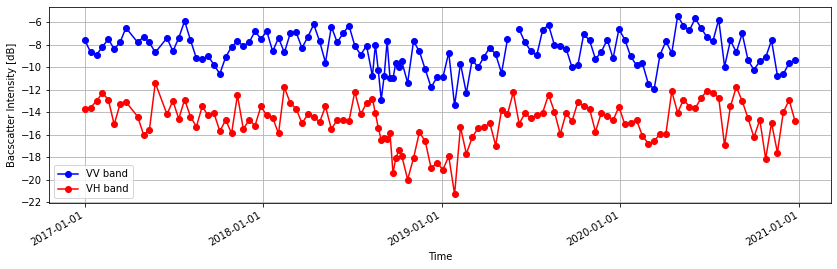

In [75]:
# create xticks
my_xticks = pd.date_range(datetime(2017,1,1), datetime(2021,1,1), freq='YS')
poi_ts_vv.plot(style='bo-', xticks=my_xticks, grid=True, figsize=(14,4), label='VV band', legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')
poi_ts_vh.plot(style='ro-', xticks=my_xticks, grid=True, figsize=(14,4), label='VH band', legend=True, xlabel='Time', ylabel='Bacscatter Intensity [dB]')